# Finding base station neighbours via the Delaunay triangulation

We will reuse the work of Delphine PAQUIRY to find base stations' neighbours.

In [1]:
# Importation of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from tqdm import tqdm # progression bar


In [2]:
# Importing database
df = pd.read_csv("../database/data.csv", sep=";", decimal=",")
df.head()

,code_op,nom_op,num_site,id_site_partage,id_station_anfr,x,y,latitude,longitude,nom_reg,...,site_ZB,site_DCC,site_strategique,site_capa_240mbps,date_ouverturecommerciale_5g,site_5g_700_m_hz,site_5g_800_m_hz,site_5g_1800_m_hz,site_5g_2100_m_hz,site_5g_3500_m_hz
0,20801,Orange,00000001A1,NaN,0802290015,687035.0,6985761.0,49.97028,2.81944,Hauts-de-France,...,0,0,0,0,NaN,0,0,0,0,0
1,20801,Orange,00000001B1,NaN,0642290151,422853.0,6249263.0,43.28861,-0.41389,Nouvelle-Aquitaine,...,0,0,0,1,2020-12-14,0,0,0,1,0
2,20801,Orange,00000001B2,NaN,0332290026,416932.0,6422196.0,44.84112,-0.58333,Nouvelle-Aquitaine,...,0,0,0,1,2021-02-22,0,0,0,0,1
3,20801,Orange,00000001B3,NaN,0472290005,511106.0,6349234.0,44.21666,0.63556,Nouvelle-Aquitaine,...,0,0,0,1,NaN,0,0,0,0,0
4,20801,Orange,00000001C1,NaN,0512290147,836824.0,6889450.0,49.09028,4.87333,Grand Est,...,0,0,0,1,NaN,0,0,0,0,0


## Useful methods



### Creation of a graph based on delaunay triangulation

In [3]:
import networkx as nx
from itertools import combinations

def delaunay_to_graph(delaunay_triangulation):
    """ Returns a Networkx Graph based on the Delaunay triangulation and the position of each node.
        
        Parameters
        ----------
        delaunay_triangulation : Delaunay
            Result of the Delaunay triangulation.

        Returns
        -------
        G : Graph
            A Networkx Graph graph.
        pos : dict
            The position of G's nodes.
    """
    G=nx.Graph()
    nodes = range(len(delaunay_triangulation.points))
    G.add_nodes_from(nodes) # adds nodes names (0 to number_of_points-1)

    for simplex in delaunay_triangulation.simplices:
        G.add_edges_from(combinations(simplex, 2))

    pos = dict(zip(nodes,delaunay_triangulation.points)) # gives each node his own position

    return G, pos

### Computation of the distance in the in km between 2 points

In [4]:
import math

def distance_geographique(pt1, pt2):
    """ Computes the distance in km between the points pt1 and pt2 (coordinates longitude, latitude).
        
        Parameters
        ----------
        pt1, pt2 : tuple
            Coordinates of the points.

        Returns
        -------
        distance : float
            Distance between pt1 and pt2.
    """
    R = 6371  # average Earth radius in kilometers
    dlat = math.radians(pt2[1] - pt1[1])
    dlon = math.radians(pt2[0] - pt1[0])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(pt1[1])) * math.cos(math.radians(pt2[1])) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance

### Quadrants

In [5]:
def create_6_quadrants(ref_point, pos):
    angles = np.degrees(np.arctan2([pos[k][1] for k in pos] - pos[ref_point][1], [pos[k][0] for k in pos] - pos[ref_point][0]))
    angles = (angles + 360) % 360

    quadrants = dict()
    for ind in range(0, 301, 60):
        quadrants[f"{ind}_{ind+60}"] = np.where((angles >= ind) & (angles < ind + 60))[0]

    return quadrants

In [6]:
def nearestNeighbour_in_quadrant(ref_point, quadrant, pos):
    """Si pas de voisin, renvoie le point"""
    min = np.inf
    nearestNeighbour = ref_point
    
    for pt2 in quadrant:
        dist = distance_geographique(pos[ref_point], pos[pt2])
        if((dist > 0) and (dist < min)):
            min = dist
            nearestNeighbour = pt2

    return nearestNeighbour

## Criterias

### Distance criteria

In [7]:
def distance_criteria(G, pos, max_distance=15):
    """ Removes all the edges of G wich are longer than max_distance.
        
        Parameters
        ----------
        G : Graph
            A Networkx Graph graph.
        pos : dict
            The position of G's nodes.
        max_distance : int (default=15)
            The maximum distance between two connected nodes (in km).
    """
    for edge in tqdm(G.edges, desc="edges"):
        if(distance_geographique(pos[edge[0]],pos[edge[1]]) > max_distance):
            G.remove_edges_from([edge])

### Quadrant criteria

In [8]:
def quadrant_criteria(G, pos):
    """ Removes all the edges of G wich doesn't respect the quadrant criteria.
        
        Parameters
        ----------
        G : Graph
            A Networkx Graph graph.
        pos : dict
            The position of G's nodes.
    """
    for node in tqdm(pos.keys(), desc="nodes"):
        quadrants = create_6_quadrants(node, pos)
        NN = set()
        for quad in quadrants.values():
            NN.add(nearestNeighbour_in_quadrant(node, quad, pos))
        for edge in G.edges:
            if((edge[0]==node) and (edge[1] not in NN)):
                G.remove_edges_from([edge])

## Plotting methods

### Plotting parameters

In [9]:
def plot_params(title, ax, long_points, lat_points):
    """ Sets the right parameters for subplots axes.
        
        Parameters
        ----------
        title : string
            Title of the subplot.
        ax : Matplotlib Axes object (default=None)
            Draw the graph in the specified Matplotlib axes.
        long_points : array
            Longitude coordinates of the points.
        lat_points : array
            Latitude coordinates of the points.
    """
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    ax.set_title(title)

    ax.tick_params(
        reset=True,
        top=False,
        right=False
    )
    
    ax.set_xlim(min(long_points)-0.05, max(long_points)+0.05)
    ax.set_ylim(min(lat_points)-0.05, max(lat_points)+0.05)

### Plot of a delaunay triangulation

In [10]:
def plot_delaunay(delaunay_triangulation, show=True, ax=None):
    """ Plots a Delaunay triangulation.
        
        Parameters
        ----------
        delaunay_triangulation : Delaunay
            Result of the Delaunay triangulation.
        show : bool (default=True)
            If True, shows the plot.
        ax : Matplotlib Axes object (default=None)
            Draw the graph in the specified Matplotlib axes.
    """
    if(ax!=None):
        ax.triplot(delaunay_triangulation.points[:,0], delaunay_triangulation.points[:,1], delaunay_triangulation.simplices, linewidth=1, c="lightblue")
        ax.plot(delaunay_triangulation.points[:,0], delaunay_triangulation.points[:,1], 'o', markersize=3, c="green")
        plot_params("Delaunay Triangulation", ax, delaunay_triangulation.points[:,0], delaunay_triangulation.points[:,1])
    else:
        plt.triplot(delaunay_triangulation.points[:,0], delaunay_triangulation.points[:,1], delaunay_triangulation.simplices, linewidth=1, c="lightblue")
        plt.plot(delaunay_triangulation.points[:,0], delaunay_triangulation.points[:,1], 'o', markersize=3, c="green")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tick_params(
            reset=True,
            top=False,
            right=False)
    if(show):
        plt.show()

### Plot of a Networkx Graph

In [11]:
def plot_graph(G, pos, show=True, **kwargs):
    """ Plots a Networkx Graph.
        
        Parameters
        ----------
        G : Graph
            The Networkx Graph graph you want to plot.
        pos : dict
            The position of G's nodes.
        show : bool (default=True)
            If True, shows the plot.
        ax : Matplotlib Axes object (default=None)
            Draw the graph in the specified Matplotlib axes.
        title : string
            The title of the subplot (works with ax).
    """
    ax = kwargs.get('ax', None)
    title = kwargs.get('title', "Delaunay Graph")

    if(ax):
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, node_color="green", edge_color="lightblue", ax=ax)
        plot_params(title, ax, [pos[k][0] for k in pos], [pos[k][1] for k in pos])
    else:
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, node_color="green", edge_color="lightblue")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tick_params(
            reset=True,
            top=False,
            right=False)
    if(show):
        plt.show()

## First try on the Gard county

### Creation of the dataframe

In [12]:
department = "Gard"

In [13]:
df_gard = df.loc[df['nom_dep'] == department]
df_gard = df_gard.drop(columns=["code_op", "id_site_partage", "id_station_anfr", "nom_reg", "nom_dep", "insee_dep", "insee_com", "site_2g", "site_3g", "site_4g", "site_5g", "mes_4g_trim", "site_ZB", "site_DCC", "site_strategique", "site_capa_240mbps", "date_ouverturecommerciale_5g", "site_5g_700_m_hz", "site_5g_800_m_hz", "site_5g_1800_m_hz", "site_5g_2100_m_hz", "site_5g_3500_m_hz"])
df_gard.head()

,nom_op,num_site,x,y,latitude,longitude,nom_com
15,Orange,00000001J4,842967.0,6319501.0,43.96000,4.78139,Villeneuve-lès-Avignon
16,Orange,00000001K2,831610.0,6351822.0,44.25305,4.64833,Pont-Saint-Esprit
84,Orange,00000003K2,810137.0,6304429.0,43.83028,4.36917,Nîmes
351,Orange,00000010K2,817019.0,6294827.0,43.74278,4.45250,Bellegarde
391,Orange,00000011K2,801064.0,6295942.0,43.75527,4.25472,Uchaud


### Base stations' number

In [14]:
providers = list(np.unique(df_gard["nom_op"]))
nb_pro = len(providers)

df_proPerDep = pd.DataFrame({
    "nom_dep" : department,
    "Free Mobile"   : [None],
    "SFR"   : [None],
    "Orange"   : [None],
    "Bouygues Telecom"   : [None],
    "Total"   : [None]
})

for pro in providers: # number of sites per provider
    count = list(df_gard["nom_op"]).count(pro)
    df_proPerDep.loc[df_proPerDep["nom_dep"]==department, pro] = count
df_proPerDep.loc[df_proPerDep["nom_dep"]==department, "Total"] = len(df_gard["num_site"])

In [15]:
df_proPerDep

,nom_dep,Free Mobile,SFR,Orange,Bouygues Telecom,Total
0,Gard,270,346,372,331,1319


### Delaunay triangulation on Free Mobile stations

In [16]:
# Selecting the provider : Free Mobile
df_gard_free = df_gard.loc[df['nom_op'] == "Free Mobile"]
df_gard_free = df_gard_free.drop(columns=['nom_op'])
df_gard_free.head()

,num_site,x,y,latitude,longitude,nom_com
85288,12204_002,721664.0,6332720.0,44.09315,3.27055,Revens
89818,30001_001,803995.0,6331865.0,44.07809,4.29843,Aigaliers
89819,30003_004,797068.0,6276765.0,43.58330,4.20149,Aigues-Mortes
89820,30003_005,796742.0,6274926.0,43.56680,4.19711,Aigues-Mortes
89821,30006_001,796886.0,6288301.0,43.68711,4.20141,Aimargues


In [17]:
# Creation of points couples for Delaunay
df_gard_free_points = np.array(df_gard_free[['longitude', 'latitude']])

In [18]:
delaunay_gard_free = Delaunay(df_gard_free_points)

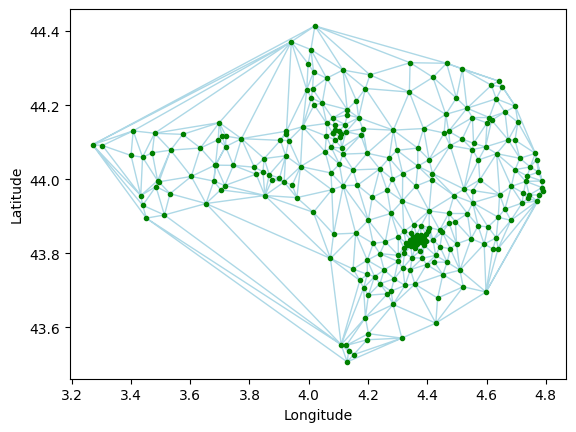

In [19]:
plot_delaunay(delaunay_gard_free)

### Creating a graph based on delaunay triangulation

In [20]:
G, pos = delaunay_to_graph(delaunay_gard_free)

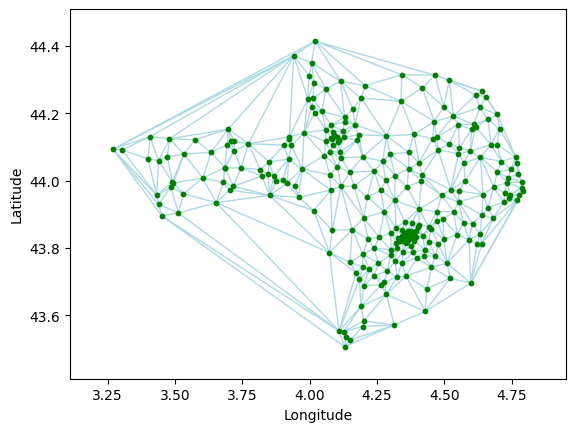

In [21]:
plot_graph(G,pos)

### Addition of criterias

In [22]:
G_dist, pos_dist = delaunay_to_graph(delaunay_gard_free)
G_quad, pos_quad = delaunay_to_graph(delaunay_gard_free)

In [23]:
distance_criteria(G_dist,pos_dist)

edges: 100%|██████████| 794/794 [00:00<00:00, 138594.09it/s]


In [24]:
quadrant_criteria(G_quad,pos_quad)

nodes: 100%|██████████| 270/270 [00:01<00:00, 162.28it/s]


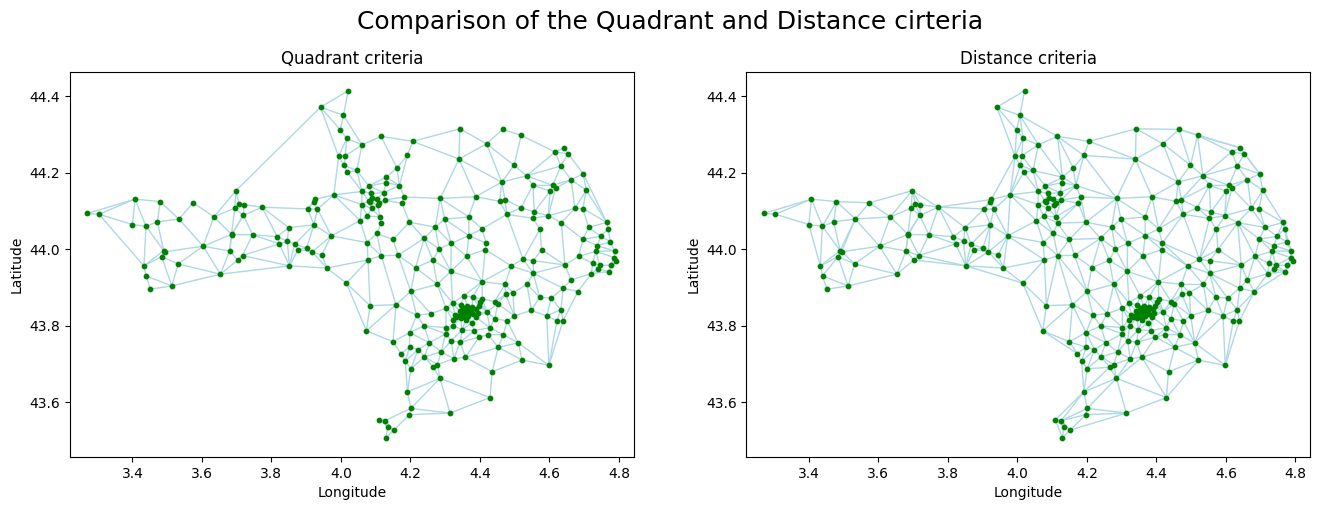

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
# plot_delaunay(delaunay_gard_free,ax=axs[0],show=False)
plot_graph(G_quad,pos_quad,ax=axs[0],show=False, title='Quadrant criteria')
plot_graph(G_dist,pos_dist,ax=axs[1],show=False, title='Distance criteria')
fig.suptitle("Comparison of the Quadrant and Distance cirteria", fontsize=18, va='center')
plt.show()

### Comparison of the results

In [26]:
distance_criteria(G,pos)

edges: 100%|██████████| 794/794 [00:00<00:00, 113529.60it/s]


In [27]:
quadrant_criteria(G,pos)

nodes: 100%|██████████| 270/270 [00:01<00:00, 160.63it/s]


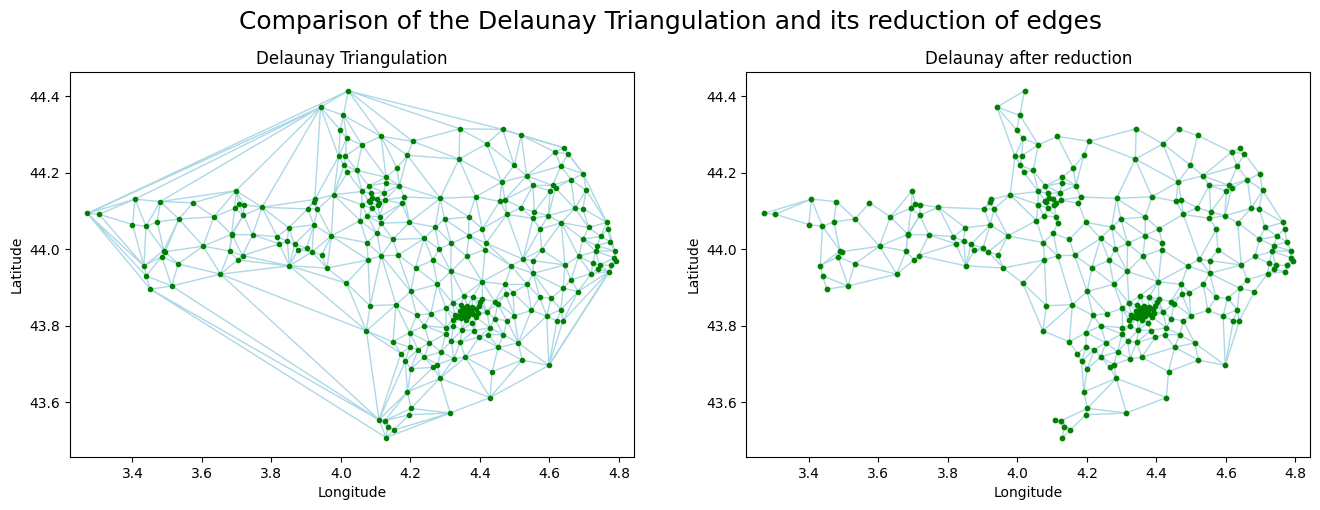

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
plot_delaunay(delaunay_gard_free,ax=axs[0],show=False)
plot_graph(G,pos,ax=axs[1],show=False,title="Delaunay after reduction")
fig.suptitle("Comparison of the Delaunay Triangulation and its reduction of edges", fontsize=18, va='center')
plt.show()

## Big Delaunay on France
Only Free Mobile

In [29]:
# Selecting the provider : Free Mobile
df_free = df.loc[df['nom_op'] == "Free Mobile"]
df_free = df_free.drop(columns=['nom_op'])
df_free.head()

,code_op,num_site,id_site_partage,id_station_anfr,x,y,latitude,longitude,nom_reg,nom_dep,...,site_ZB,site_DCC,site_strategique,site_capa_240mbps,date_ouverturecommerciale_5g,site_5g_700_m_hz,site_5g_800_m_hz,site_5g_1800_m_hz,site_5g_2100_m_hz,site_5g_3500_m_hz
82661,20815,01002_001,ZPB01412,0010990247,887004.0,6548221.0,46.00797,5.41702,Auvergne-Rhône-Alpes,Ain,...,1,0,0,0,NaN,0,0,0,0,0
82662,20815,01004_001,NaN,0010990004,883573.0,6541985.0,45.95278,5.37028,Auvergne-Rhône-Alpes,Ain,...,0,0,0,1,2020-12-15,1,0,0,0,0
82663,20815,01004_002,NaN,0010990041,881600.0,6544701.0,45.97775,5.34586,Auvergne-Rhône-Alpes,Ain,...,0,0,0,1,2021-02-16,1,0,0,0,0
82664,20815,01004_005,NaN,0010990393,881006.0,6543173.0,45.96416,5.33761,Auvergne-Rhône-Alpes,Ain,...,0,0,0,1,2023-09-25,1,0,0,0,0
82665,20815,01005_001,NaN,0010990281,847469.0,6544900.0,45.98782,4.90522,Auvergne-Rhône-Alpes,Ain,...,0,0,0,1,2020-12-15,1,0,0,0,0


In [30]:
# Creation of points couples for Delaunay
df_free_points = np.array(df_free[['longitude', 'latitude']])

In [31]:
delaunay_free = Delaunay(df_free_points)

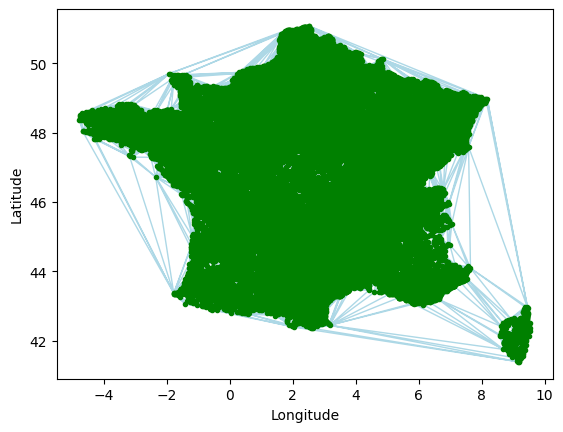

In [32]:
plot_delaunay(delaunay_free)

In [33]:
G_france, pos_france = delaunay_to_graph(delaunay_free)

In [34]:
distance_criteria(G_france,pos_france)

edges: 100%|██████████| 77819/77819 [00:00<00:00, 171758.18it/s]


In [35]:
quadrant_criteria(G_france,pos_france)

nodes:   0%|          | 84/25949 [00:22<1:57:48,  3.66it/s]


KeyboardInterrupt: 

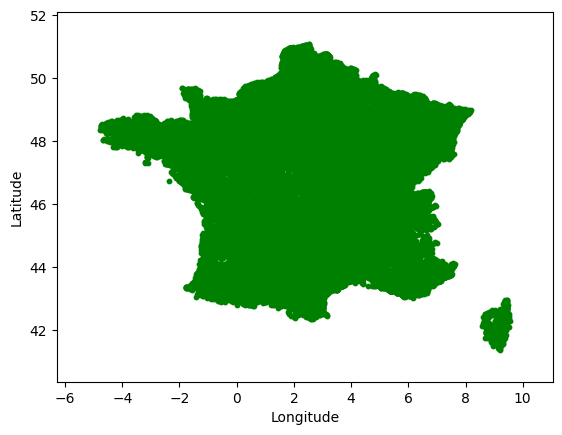

In [ ]:
plot_graph(G_france,pos_france)